In [1]:
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets

import args
import utils
from networks import LossNetwork, StyleBankNet

"""********Important*******"""
args.continue_training = True # change to your setting
"""************************"""

device = args.device

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [2]:
cat args.py

import torch
import os

device = torch.device("cuda")

batch_size = 5
lr = 0.001
T = 2
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1000000
REG_WEIGHT = 1e-5

continue_training = True

CONTENT_IMG_DIR = 'test/content'
STYLE_IMG_DIR = 'test/style'
MODEL_WEIGHT_DIR = 'weights_new'
BANK_WEIGHT_DIR = os.path.join(MODEL_WEIGHT_DIR, 'bank')
BANK_WEIGHT_PATH = os.path.join(BANK_WEIGHT_DIR, '{}.pth')
MODEL_WEIGHT_PATH = os.path.join(MODEL_WEIGHT_DIR, 'model.pth')
ENCODER_WEIGHT_PATH = os.path.join(MODEL_WEIGHT_DIR, 'encoder.pth')
DECODER_WEIGHT_PATH = os.path.join(MODEL_WEIGHT_DIR, 'decoder.pth')
GLOBAL_STEP_PATH = os.path.join(MODEL_WEIGHT_DIR, 'global_step.log')

K = 1000
MAX_ITERATION = 300 * K
SAVE_MODEL_POINT = 10 * K
ADJUST_LR_ITER = 10 * K
LOG_ITER = 1 * K

In [3]:
!rm -rf test/style/.ipynb_checkpoints/

In [4]:
os.listdir('test/style')

['git_style']

In [5]:
"""
Load Dataset
"""
content_dataset = datasets.ImageFolder(root=args.CONTENT_IMG_DIR, transform=utils.content_img_transform)
content_dataloader = torch.utils.data.DataLoader(content_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

In [6]:
"""
Display content images
"""

'\nDisplay content images\n'

In [7]:
"""
Load Style Dataset
"""
style_dataset = datasets.ImageFolder(root=args.STYLE_IMG_DIR, transform=utils.style_img_transform)
style_dataset = torch.cat([img[0].unsqueeze(0) for img in style_dataset], dim=0)
style_dataset = style_dataset.to(device)

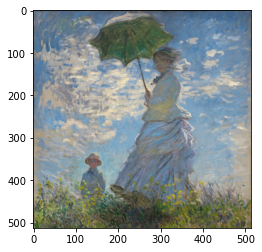

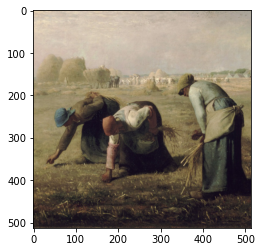

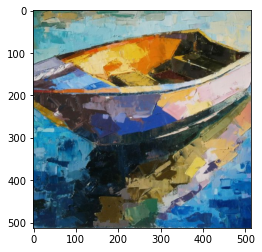

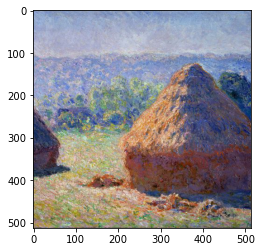

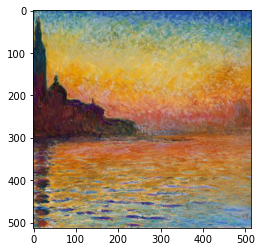

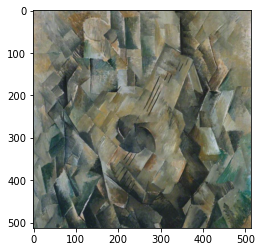

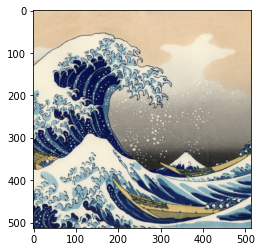

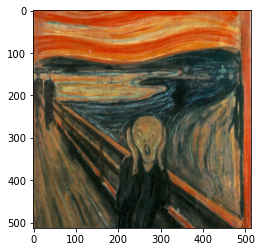

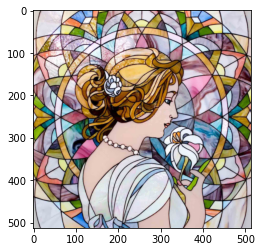

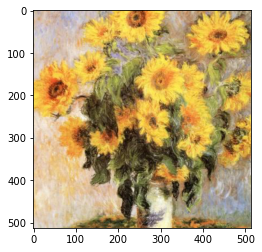

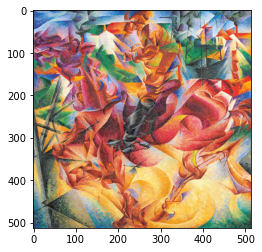

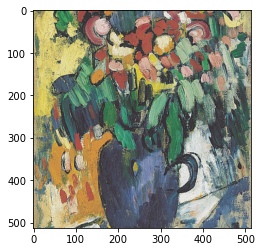

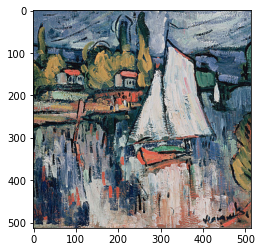

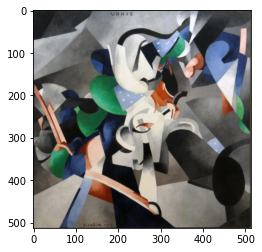

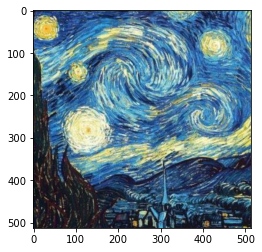

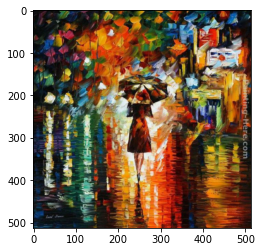

In [8]:
"""
Display style images
"""
for img in style_dataset:
    utils.showimg(img)

In [9]:
"""
Define Model and Loss Network (vgg16)
"""
model = StyleBankNet(len(style_dataset)).to(device)

if args.continue_training:
    if os.path.exists(args.GLOBAL_STEP_PATH):
        with open(args.GLOBAL_STEP_PATH, 'r') as f:
            global_step = int(f.read())
    else:
        raise Exception('cannot find global step file')
    if os.path.exists(args.MODEL_WEIGHT_PATH):
        model.load_state_dict(torch.load(args.MODEL_WEIGHT_PATH))
        print("load bank weight")
    else:
        raise Exception('cannot find model weights')
else:
    if not os.path.exists(args.MODEL_WEIGHT_DIR):
        os.mkdir(args.MODEL_WEIGHT_DIR)
    if not os.path.exists(args.BANK_WEIGHT_DIR):
        os.mkdir(args.BANK_WEIGHT_DIR)
    global_step = 0
        
optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer_ae = optim.Adam(model.parameters(), lr=args.lr)
loss_network = LossNetwork().to(device)

load bank weight


/home/z7wei/Stylebank/networks.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/z7wei/Stylebank/networks.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [10]:
!rm -rf ECE269/test_sample/.ipynb_checkpoints/

In [11]:
"""
Testing
"""
style_id = list(range(len(style_dataset)))
style_id_idx = 0
style_id_seg = []
for i in range(0, len(style_dataset), args.batch_size):
    style_id_seg.append(style_id[i:i+args.batch_size])
style_id_seg

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15]]

In [12]:
!rm -rf test/test_single/.ipynb_checkpoints/

In [13]:
"""
Load Test Dataset
"""
test_folder = "./ECE269/sunset/"
output_root = "sunset_style"

files = os.listdir(os.path.join(test_folder, os.listdir(test_folder)[0]))
files

['sunset.png']

In [22]:
!rm -r ECE269/sunset/.ipynb_checkpoints/

In [23]:
test_dataset = datasets.ImageFolder(root=test_folder, transform=utils.content_img_fill)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(files), num_workers=1)

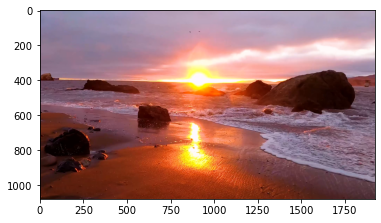

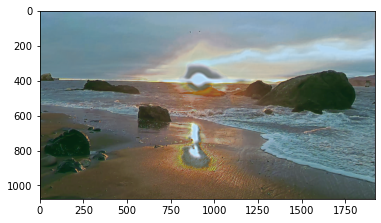

Show style: [0]


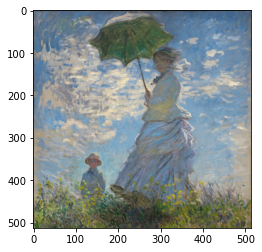

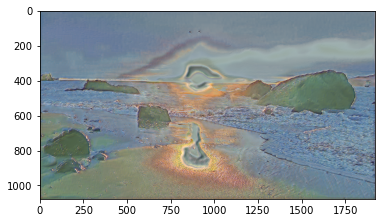

Show style: [0]


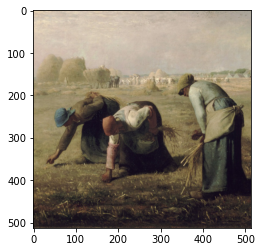

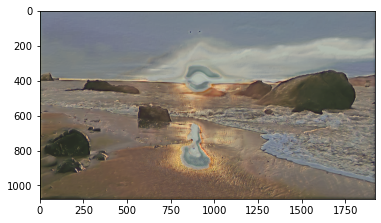

Show style: [0]


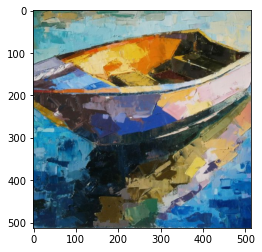

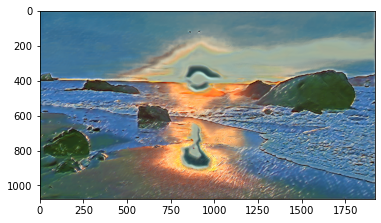

Show style: [0]


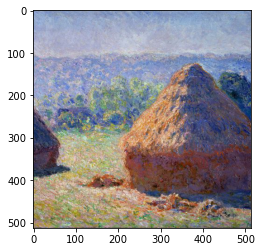

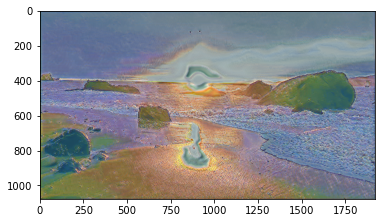

Show style: [0]


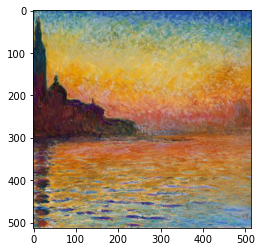

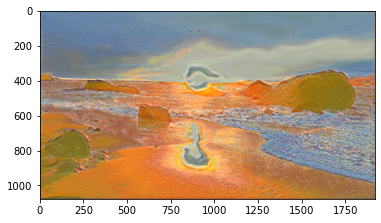

Show style: [0]


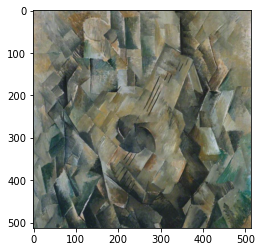

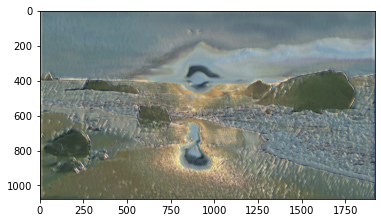

Show style: [0]


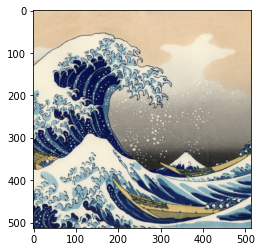

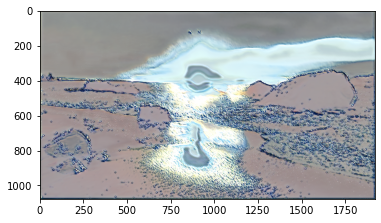

Show style: [0]


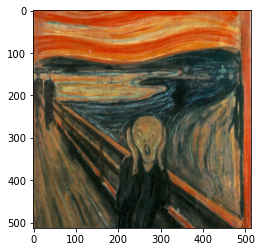

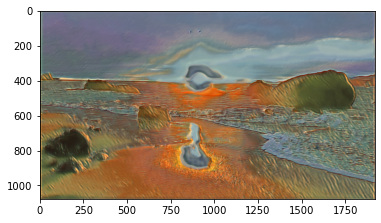

Show style: [0]


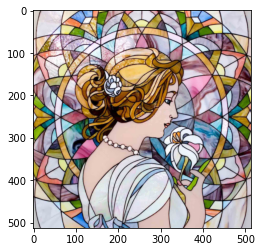

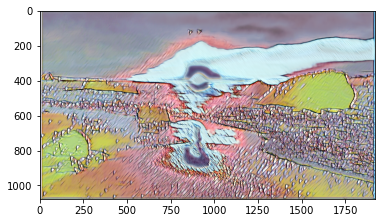

Show style: [0]


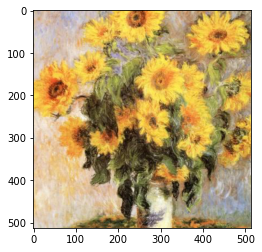

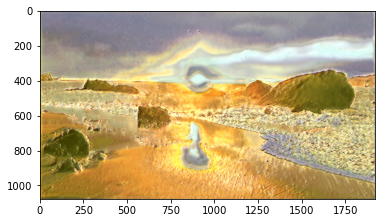

Show style: [0]


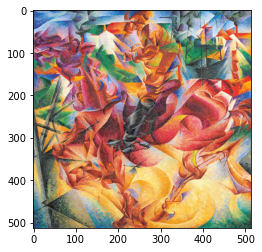

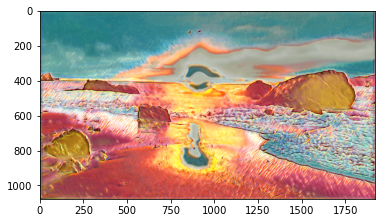

Show style: [0]


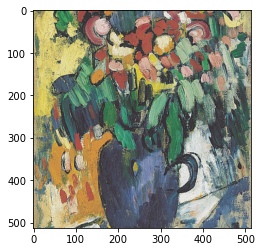

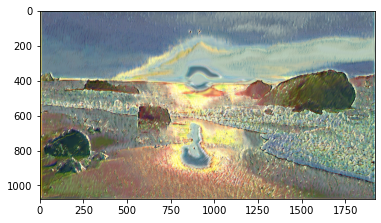

Show style: [0]


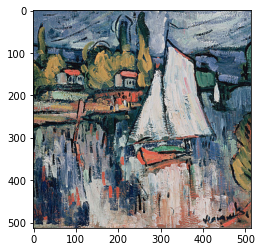

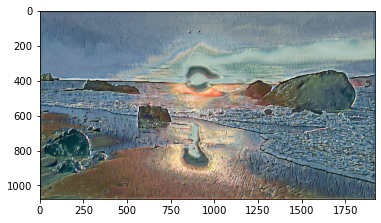

Show style: [0]


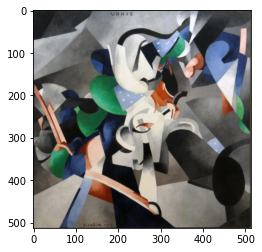

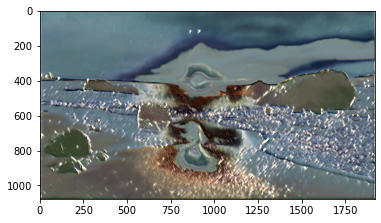

Show style: [0]


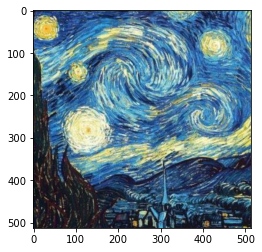

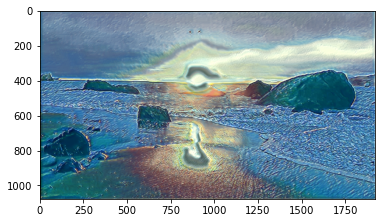

Show style: [0]


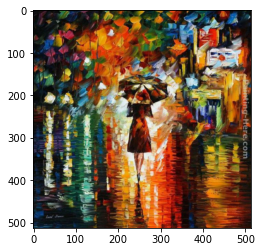

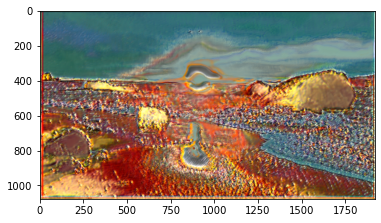

In [24]:
from torchvision.utils import save_image

for i, data in enumerate(test_dataloader, 0):
    batch = data[0]
    batch_size = batch.shape[0]
#     data = data[0].repeat(batch_size, 1, 1, 1)
    for j in range(batch_size):
        image = batch[j][None,:].to(device)
        utils.showimg(image[0].cpu())
        save_image(image[0].cpu(), output_root+"/original_"+str(j)+".jpg")
    
        output_image = model(image)
        utils.showimg(output_image[0].cpu().detach())
        save_image(output_image[0].cpu().detach(), output_root+"/decode_"+str(j)+".jpg")
        del output_image
        torch.cuda.empty_cache()
        
        for i in style_id:
            print("Show style:", utils.get_sid_batch(style_id_seg[0], batch_size))
            utils.showimg(style_dataset[i])
            save_image(style_dataset[i], output_root+"/"+str(i)+"_style.jpg")
            output_image = model(image, utils.get_sid_batch([i]*1, 1))
            utils.showimg(output_image[0].cpu().detach())
            save_image(output_image[0].cpu().detach(), output_root+"/"+str(i)+"_"+str(j)+".jpg")
            del output_image
            torch.cuda.empty_cache()
            
        del image
        torch.cuda.empty_cache()
    break